In this tutorial we analyse how the energy in a MLP neural network (trained with PC) could be used to assess if 
test data belongs to in-distribution or out-of-distribution. We will use the energy of the network as a measure of
surprise.

1. Prepare the in-distribution (MNIST) and out-of-distribution (FashionMNIST) datasets.
    - note that the interpolation threshold for regular trainset size of (n=60000) would be (with K=10): I_th = n*K = 600 000 samples,
    one would need a 3-layer-MLP with 800 hidden nodes (h=800) to have approx. 1.2x10^6 parameters and thus be twice as big as the interpolation threshold 
    in order to guarantee not fitting a model which might below the interpolation threshold I_th or in the "classical" under-parameterized regime but 
    instead ensure to fit a model in the "modern" over-parameterized regime. We achieve this by a) training for long enough and b) ensuring that the model 
    has the appropriate capacity (i.e., number of parameters) which we control with h (i.e., the number of hidden nodes in each layer).
    - given that the complete training data (n=60000) size would require unnecessary big neural networks (increased compute time due to increased 
    hidden size h) we will use a subset of the complete training data (n_subset_size=) to make it sufficient to train networks with half the amount of 
    samples which will give use a reduce interpolation threshold of I_th (= 300 000 samples). Given fixed K (K=10 classes) we can use a 
    training subset_size n_subset_size of 30 000 samples. In this case, the required hidden size h to achieve a 3-layer-MLP with at least twice as many 
    parameters as the chosen training set size would be approx. h≈512 - which would give use a neural network with approx. 6.5x10^5 (650 000) parameters 
    (so roughly half, 6x10^5 parameters, of what we required above).
2. Training phase: Train a MLP neural network with PC on MNIST.
3. Testing phase: Test the network with MNIST and FashionMNIST.
4. Plots and tables:
    1. Plot the energy distribution histograms to visualize the distribution and spread of the energy for in-distribution and out-of-distribution 
    data, use separate histograms for each dataset and overlay them for comparison.
    2. Create box plots to show the median, quartiles, and outliers of the energies to summarize the central tendency and variability of energies.
    3. Generate a Receiver Operating Characteristic (ROC) curve based on the energies to assess the model's ability to distinguish between 
    in-distribution and out-of-distribution data. Plot true positive rate (sensitivity) against false positive rate (1-specificity) for different 
    threshold values of energies.
    4. Create a table summarizing key statistics (mean, median, standard deviation) of energies for MNIST and FashionMNIST. Include columns for 
    MNIST and FashionMNIST with rows for each statistic.
    5. Create a scatter plot of energies versus prediction confidence (max softmax value) for both MNIST and FashionMNIST. Goal is to investigate 
    the relationship/correlation between model confidence and energy value. Use different colors or markers for MNIST and FashionMNIST data points.




In [1]:
# built-in
import json
import time
import os
import argparse

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# 3rd party
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# own
from helpers import get_dataloaders, create_new_test_loader_with_batch_size

In [2]:
###################################### start of model related code ##########################################

from typing import Callable

# Core dependencies
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
print(jax.default_backend())  # print backend type

# pcax
import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu


# Model definition
class Model(pxc.EnergyModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        nm_layers: int,
        act_fn: Callable[[jax.Array], jax.Array]
    ) -> None:
        super().__init__()
        self._dim_input = input_dim
        self._dim_output = output_dim
        
        self.act_fn = px.static(act_fn)

        self.layers = [pxnn.Linear(input_dim, hidden_dim)] + [
            pxnn.Linear(hidden_dim, hidden_dim) for _ in range(nm_layers - 2)
        ] + [pxnn.Linear(hidden_dim, output_dim)]
        
        self.vodes = [
            pxc.Vode((hidden_dim,)) for _ in range(nm_layers - 1)
        ] + [pxc.Vode((output_dim,), pxc.ce_energy)]

        self.vodes[-1].h.frozen = True

    def num_parameters(self):
        """
        Calculate the total number of parameters in the model.
        Args:
            model: The model object containing layers with weights and biases.
        Returns:
            int: Total number of parameters in the model.
        """
        return sum(layer.nn.weight.size + layer.nn.bias.size for layer in self.layers)

    def save(self, file_name):
        pxu.save_params(self, file_name)


    def __call__(self, x, y):
        for v, l in zip(self.vodes[:-1], self.layers[:-1]):
            x = v(self.act_fn(l(x)))
        x = self.vodes[-1](self.layers[-1](x))
        
        if y is not None:
            self.vodes[-1].set("h", y)
        return self.vodes[-1].get("u")


# Training and evaluation functions
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: Model):
    return model(x, y)

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: Model):
    y_ = model(x, None)
    return jax.lax.pmean(model.energy().sum(), "batch"), y_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, y: jax.Array, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    model.train()

    # print the shape of the x and y to debug and specify in what function the print statement is
    #print(f"In train_on_batch() the shapes are: x shape: {x.shape}, y shape: {y.shape}")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)

    # reinitialise the optimiser state between different batches (NOTE: this is just educational and not needed here because the SGD we use is not-stateful due to lack of momentum)
    optim_h.init(pxu.Mask(pxc.VodeParam)(model))

    # inference steps
    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            _, g = pxf.value_and_grad(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]), has_aux=True)(energy)(x, model=model)
            optim_h.step(model, g["model"], True)

    # learning (weight update) step
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(x, model=model)
        optim_w.step(model, g["model"])

@pxf.jit()
def eval_on_batch(x: jax.Array, y: jax.Array, *, model: Model):
    model.eval()

    # print the shape of the x and y to debug and specify in what function the print statement is
    #print(f"In eval_on_batch() the shapes are: x shape: {x.shape}, y shape: {y.shape}")

    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        y_ = forward(x, y, model=model).argmax(axis=-1)
        e = model.vodes[-1].energy()
    # print the shape of the predictions y_ to debug and specify in what function the print statement is
    #print(f"In eval_on_batch() the shapes of predictions are: y_ shape: {y_.shape}")
    
    # Convert y from one-hot encoding to class indices
    y_indices = y.argmax(axis=-1)
    #print(f"In eval_on_batch() the shapes of y_indices are: y_indices shape: {y_indices.shape}")
    
    return (y_ == y_indices).mean(), y_, e.mean()

@pxf.jit()
def predict_with_logits_on_batch(x: jax.Array, *, model: Model):
    model.eval()
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        logits_ = forward(x, None, model=model)
        y_ = logits_.argmax(axis=-1)
    # print the shape of the logits and the y_ to debug and specify in what function the print statement is
    #print(f"In predict_with_logits_on_batch() the shapes are: logits shape: {logits_.shape}, y_ shape: {y_.shape}")  # Debugging line
    return y_, logits_

def train(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    for x, y in dl:
        train_on_batch(T, x, jax.nn.one_hot(y, 10), model=model, optim_w=optim_w, optim_h=optim_h)

    # print the shape of x and y to debug and specify in what function the print statement is
    #print(f"In train() the shapes are: x shape: {x.shape}, y shape: {y.shape}")  # Debugging line
      
def eval(dl, *, model: Model):
    acc = []
    es = []
    ys_ = []
    for x, y in dl:
        a, y_, e = eval_on_batch(x, jax.nn.one_hot(y, 10), model=model)
        acc.append(a)
        es.append(e)
        ys_.append(y_)

    # print the shape of x and y to debug and specify in what function the print statement is
    #print(f"In eval() the shapes are: x shape: {x.shape}, y shape: {y.shape}")  # Debugging line

    return float(np.mean(acc)), np.concatenate(ys_), float(np.mean(es))

def predict_with_logits(dl, *, model: Model):
    ys_ = []
    logits_ = []
    for x, _ in dl:
        y_, logits = predict_with_logits_on_batch(x, model=model)
        ys_.append(y_)
        logits_.append(logits)
    return np.concatenate(ys_), np.concatenate(logits_)

# write a function that given an input and an output, finds the state of the model that minimises 
# the energy via T inference steps using the model's optimiser optim_h on the model's vodes

@pxf.jit(static_argnums=0)
def eval_inference_on_batch(T: int, x: jax.Array, y: jax.Array, *, model: Model, optim_h: pxu.Optim):
    model.eval()

    # init step and also compute the energy of the model with the given input and output before the inference steps (i.e. without minimising the energy)
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model) # this works
        # forward(x, None, model=model) # this cannot work because we need to tell the model the output y for every new input batch x
        e_pre_ = model.energy()
    
    # show the shape of e_pre_ before the inference steps and specify the function name in which the print statement is
    #print("In eval_inference_on_batch() the shape of e_pre_ before the inference steps is: ", e_pre_.shape)  # Debugging line

    # shorthand for value and grad computation on the energy function
    inference_step = pxf.value_and_grad(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]), has_aux=True)(energy)

    # reinitialise the optimiser state between different batches (NOTE: this is just educational and not needed here because the SGD we use is not-stateful due to lack of momentum)
    optim_h.init(pxu.Mask(pxc.VodeParam)(model))

    # inference steps
    for T_i in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            _, g = inference_step(x, model=model)
            optim_h.step(model, g["model"], True)
        
    # Only compute and store energy on the last iteration
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        #e_post_luca, _ = energy(x, model=model) # this returns average energy over batch as single scalar value. This works even without supplying y. because the y value is set in the forward pass above.
        
        forward(x, y, model=model) # this works
        e_post_ = model.energy() # this returns energy per sample in the batch

    # show the shape of e_pre_ before the inference steps and specify the function name in which the print statement is
    #print("In eval_inference_on_batch() the shape of e_post_ after the inference steps is: ", e_post_.shape)

    # print that the function was successfully executed
    #print("eval_inference_on_batch() executed successfully")  # Debugging line

    return e_pre_, e_post_

def eval_inference(dl, T, *, model: Model, optim_h: pxu.Optim):
    for x, y in dl:
        eval_inference_on_batch(T, x, jax.nn.one_hot(y, 10), model=model, optim_h=optim_h)

###################################### end of model related code ##########################################

gpu


2024-06-03 10:11:47.926416: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
# ID data

dataset_name = "mnist"
train_subset_size = 30000
batch_size = 128
noise_level = 0.0 # this means that the validation set will be 20% of the train_subset_size (6000 samples)
# get the ID dataloaders
dataset = get_dataloaders(dataset_name, train_subset_size, batch_size, noise_level)
# Check the sizes of the datasets
print(f"Training set: {len(dataset.train_loader.sampler)} samples")
print(f"Validation set: {len(dataset.val_loader.sampler)} samples")
print(f"Test set: {len(dataset.test_loader.dataset)} samples")

# OOD data

OOD_dataset_name = "fashionmnist"
# get the OOD dataloaders
OOD_dataset = get_dataloaders(OOD_dataset_name, train_subset_size, batch_size, noise_level)
# Check the sizes of the datasets
print(f"OOD Training set: {len(OOD_dataset.train_loader.sampler)} samples")
print(f"OOD Validation set: {len(OOD_dataset.val_loader.sampler)} samples")
print(f"OOD Test set: {len(OOD_dataset.test_loader.dataset)} samples")

Training set: 30000 samples
Validation set: 6000 samples
Test set: 10000 samples
OOD Training set: 30000 samples
OOD Validation set: 6000 samples
OOD Test set: 10000 samples


In [4]:
w_learning_rate = 1e-2
h_learning_rate = 1e-2
T = 10

# create a dummy model to see if the model is working
model = Model(
    input_dim=784,
    hidden_dim=512,
    output_dim=10,
    nm_layers=3,
    act_fn=jax.nn.gelu
)

# print the model
print(model)
# now print number of parameters in the model
print(f"Number of parameters: {model.num_parameters()}")

(Model):
  ._dim_input: 784
  ._dim_output: 10
  .layers[0].nn.weight: LayerParam([512,784], float32)
  .layers[0].nn.bias: LayerParam([512], float32)
  .layers[1].nn.weight: LayerParam([512,512], float32)
  .layers[1].nn.bias: LayerParam([512], float32)
  .layers[2].nn.weight: LayerParam([10,512], float32)
  .layers[2].nn.bias: LayerParam([10], float32)
  .vodes[0].h: VodeParam(None)
  .vodes[0].cache: Cache(params=None)
  .vodes[1].h: VodeParam(None)
  .vodes[1].cache: Cache(params=None)
  .vodes[2].h: VodeParam(None)
  .vodes[2].cache: Cache(params=None)
Number of parameters: 669706


In [5]:
nm_epochs = 75

# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jax.numpy.zeros((batch_size, model._dim_input)), None, model=model)
    optim_h = pxu.Optim(optax.sgd(h_learning_rate), pxu.Mask(pxc.VodeParam)(model))
    optim_w = pxu.Optim(optax.sgd(w_learning_rate, momentum=0.95), pxu.Mask(pxnn.LayerParam)(model))

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for e in range(nm_epochs):

    # train the model
    train(dataset.train_loader, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
    
    # evaluate the model and get accuracies and losses
    a_train, ys_train, e_train = eval(dataset.train_loader, model=model)
    a_val, ys_val, e_val = eval(dataset.val_loader, model=model)

    train_losses.append(e_train)
    val_losses.append(e_val)
    train_accuracies.append(a_train)
    val_accuracies.append(a_val)

    print(f"Epoch {e+1}/{nm_epochs} - Train Acc: {a_train:.4f} - Val Acc: {a_val:.4f} - Train Loss: {e_train:.4f} - Val Loss: {e_val:.4f}")

# ID test accuracy
a_test, ys_test, e_test = eval(dataset.test_loader, model=model)
print(f"Test Acc: {a_test:.4f} - Test Loss: {e_test:.4f}")

# OOD test accuracy
OOD_a_test, OOD_ys_test, OOD_e_test = eval(OOD_dataset.test_loader, model=model)
print(f"OOD Test Acc: {OOD_a_test:.4f} - OOD Test Loss: {OOD_e_test:.4f}")

"""
NOTE: 
Having run the model for 500 epochs we can see from:
Epoch 55/500 - Train Acc: 0.9862 - Val Acc: 0.9654 - Train Loss: 0.0462 - Val Loss: 0.1270
Epoch 56/500 - Train Acc: 0.9873 - Val Acc: 0.9645 - Train Loss: 0.0444 - Val Loss: 0.1273
Epoch 57/500 - Train Acc: 0.9869 - Val Acc: 0.9657 - Train Loss: 0.0449 - Val Loss: 0.1267
Epoch 58/500 - Train Acc: 0.9881 - Val Acc: 0.9642 - Train Loss: 0.0419 - Val Loss: 0.1267
Epoch 59/500 - Train Acc: 0.9885 - Val Acc: 0.9669 - Train Loss: 0.0411 - Val Loss: 0.1188
Epoch 60/500 - Train Acc: 0.9888 - Val Acc: 0.9655 - Train Loss: 0.0402 - Val Loss: 0.1248
Epoch 61/500 - Train Acc: 0.9897 - Val Acc: 0.9650 - Train Loss: 0.0390 - Val Loss: 0.1254
Epoch 62/500 - Train Acc: 0.9894 - Val Acc: 0.9662 - Train Loss: 0.0386 - Val Loss: 0.1235
Epoch 63/500 - Train Acc: 0.9900 - Val Acc: 0.9645 - Train Loss: 0.0372 - Val Loss: 0.1260
That a good minimal validation loss is achieved around epoch 59.
Hence we decide to train the model for roughly 75 epochs (a little bit more than 59, to acknowledge the stochasticity of the training process).
"""

/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In train_on_batch() the shapes are: x shape: (128, 784), y shape: (128, 10)


/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/75 - Train Acc: 0.8507 - Val Acc: 0.8490 - Train Loss: 0.5470 - Val Loss: 0.5455
Epoch 2/75 - Train Acc: 0.8862 - Val Acc: 0.8828 - Train Loss: 0.3876 - Val Loss: 0.3862
Epoch 3/75 - Train Acc: 0.9042 - Val Acc: 0.8998 - Train Loss: 0.3302 - Val Loss: 0.3310
Epoch 4/75 - Train Acc: 0.9118 - Val Acc: 0.9081 - Train Loss: 0.3011 - Val Loss: 0.3033
Epoch 5/75 - Train Acc: 0.9193 - Val Acc: 0.9115 - Train Loss: 0.2748 - Val Loss: 0.2804
Epoch 6/75 - Train Acc: 0.9251 - Val Acc: 0.9195 - Train Loss: 0.2565 - Val Loss: 0.2653
Epoch 7/75 - Train Acc: 0.9302 - Val Acc: 0.9253 - Train Loss: 0.2387 - Val Loss: 0.2494
Epoch 8/75 - Train Acc: 0.9348 - Val Acc: 0.9287 - Train Loss: 0.2243 - Val Loss: 0.2366
Epoch 9/75 - Train Acc: 0.9388 - Val Acc: 0.9324 - Train Loss: 0.2109 - Val Loss: 0.2287
Epoch 10/75 - Train Acc: 0.9413 - Val Acc: 0.9368 - Train Loss: 0.2013 - Val Loss: 0.2198
Epoch 11/75 - Train Acc: 0.9442 - Val Acc: 0.9368 - Train Loss: 0.1903 - Val Loss: 0.2129
Epoch 12/75 - Train

'\nNOTE: \nHaving run the model for 500 epochs we can see from:\nEpoch 55/500 - Train Acc: 0.9862 - Val Acc: 0.9654 - Train Loss: 0.0462 - Val Loss: 0.1270\nEpoch 56/500 - Train Acc: 0.9873 - Val Acc: 0.9645 - Train Loss: 0.0444 - Val Loss: 0.1273\nEpoch 57/500 - Train Acc: 0.9869 - Val Acc: 0.9657 - Train Loss: 0.0449 - Val Loss: 0.1267\nEpoch 58/500 - Train Acc: 0.9881 - Val Acc: 0.9642 - Train Loss: 0.0419 - Val Loss: 0.1267\nEpoch 59/500 - Train Acc: 0.9885 - Val Acc: 0.9669 - Train Loss: 0.0411 - Val Loss: 0.1188\nEpoch 60/500 - Train Acc: 0.9888 - Val Acc: 0.9655 - Train Loss: 0.0402 - Val Loss: 0.1248\nEpoch 61/500 - Train Acc: 0.9897 - Val Acc: 0.9650 - Train Loss: 0.0390 - Val Loss: 0.1254\nEpoch 62/500 - Train Acc: 0.9894 - Val Acc: 0.9662 - Train Loss: 0.0386 - Val Loss: 0.1235\nEpoch 63/500 - Train Acc: 0.9900 - Val Acc: 0.9645 - Train Loss: 0.0372 - Val Loss: 0.1260\nThat a good minimal validation loss is achieved around epoch 59.\nHence we decide to train the model for ro

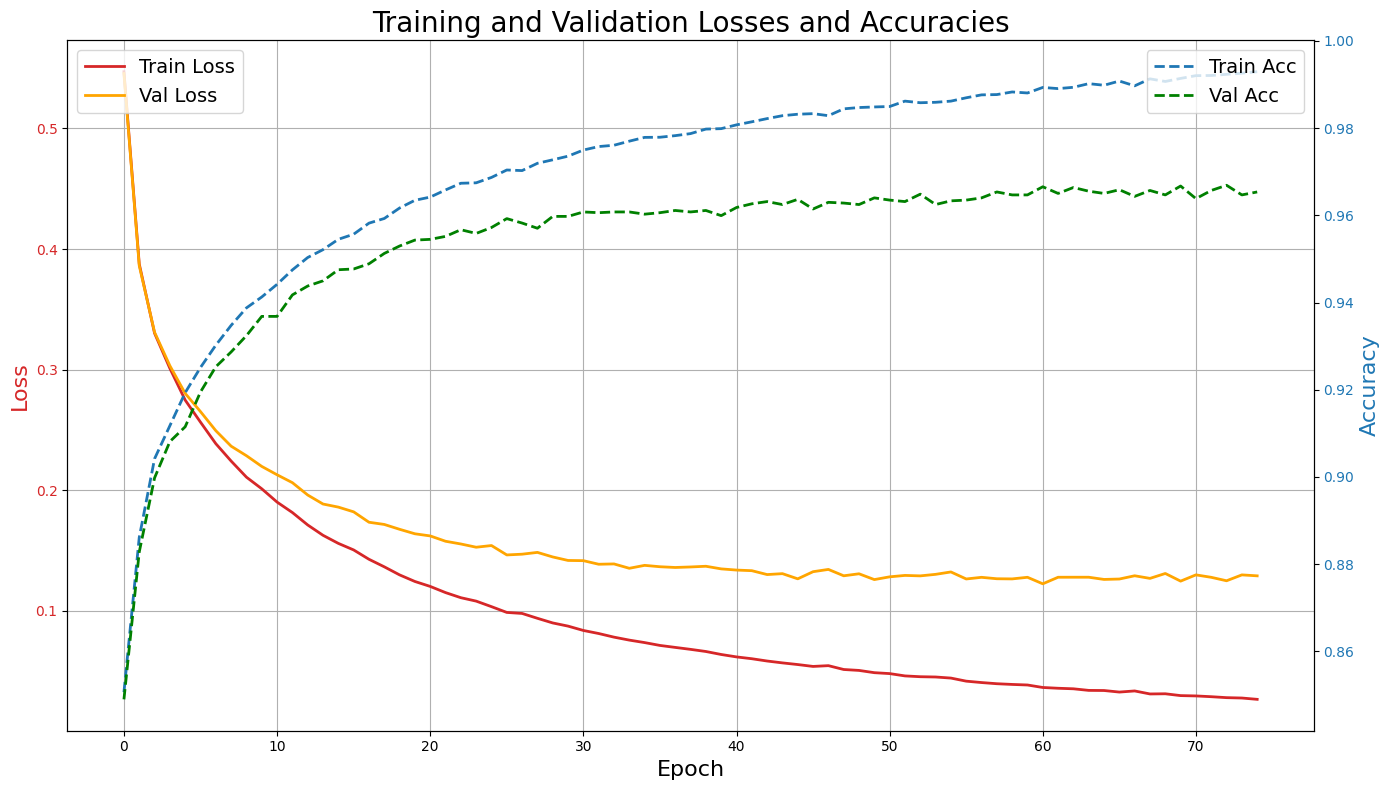

In [6]:
# Assuming train_losses, val_losses, train_accuracies, val_accuracies are defined

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot training and validation losses
color = 'tab:red'
ax1.set_xlabel('Epoch', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16, color=color)
ax1.plot(train_losses, color=color, label="Train Loss", linewidth=2)
ax1.plot(val_losses, color="orange", label="Val Loss", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper left", fontsize=14)
ax1.grid(True)

# Create a twin Axes sharing the x-axis for accuracies
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', fontsize=16, color=color)
ax2.plot(train_accuracies, color=color, linestyle="--", label="Train Acc", linewidth=2)
ax2.plot(val_accuracies, color="green", linestyle="--", label="Val Acc", linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper right", fontsize=14)

# Title and layout adjustments
plt.title('Training and Validation Losses and Accuracies', fontsize=20)
fig.tight_layout()
plt.show()

In [7]:
# now compute the prediction and logits for the test set
ys_test, logits_test = predict_with_logits(dataset.test_loader, model=model)

# now print the shape of the logits_test and the ys_test
print(f"logits_test shape: {logits_test.shape}, ys_test shape: {ys_test.shape}")

# show the first row of the logits_test and the ys_test
print(f"logits_test[0]: {logits_test[0]}")
print()
print(f"ys_test[0]: {ys_test[0]}")

# now compute the softmax of the logits_test for the first row
logits_test_softmax = jax.nn.softmax(logits_test[0])
print(f"logits_test_softmax[0]: {logits_test_softmax}")

# now compute the sum of the logits_test_softmax
print(f"sum of the logits_test_softmax[0]: {logits_test_softmax.sum()}")

logits_test shape: (9984, 10), ys_test shape: (9984,)
logits_test[0]: [  2.3261707  -3.547469    1.2956623   4.257816   -6.61504     0.649318
 -14.600483   18.40595    -2.38972     0.5787098]

ys_test[0]: 7
logits_test_softmax[0]: [1.03905769e-07 2.92247643e-10 3.70762407e-08 7.17039370e-07
 1.35994575e-11 1.94264054e-08 4.62901430e-15 9.99999166e-01
 9.30154564e-10 1.81020461e-08]
sum of the logits_test_softmax[0]: 1.0


In [8]:
# create new custom test loader with batch size equal to the entire test set
full_test_loader = create_new_test_loader_with_batch_size(test_loader=dataset.test_loader, new_batch_size=len(dataset.test_loader.dataset))

# Fetch all data from the loader
for batch in full_test_loader:
    inputs, targets = batch

# Convert to JAX arrays
X_test_jax = jnp.array(inputs)
y_test_jax = jnp.array(targets)

# Print shapes to verify
print(f"X_test_jax shape: {X_test_jax.shape}")
print(f"y_test_jax shape: {y_test_jax.shape}")

/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


X_test_jax shape: (10000, 784)
y_test_jax shape: (10000,)


In [9]:
# Function to apply softmax on every sample and select the max softmax value
def max_softmax_per_sample(logits):
    softmax_values = jax.nn.softmax(logits, axis=-1)
    max_softmax_values = jnp.max(softmax_values, axis=-1)
    return max_softmax_values

# Clear VodeParams
model.clear_params(pxc.VodeParam)

# Compute the prediction and logits for the full_test_loader
ys_test, logits_test = predict_with_logits(full_test_loader, model=model)

# Convert the outputs to JAX arrays
ys_test_jax = jnp.array(ys_test)
logits_test_jax = jnp.array(logits_test)

# Print shapes to verify
print(f"logits_test shape: {logits_test.shape}, ys_test shape: {ys_test.shape}")

# Show the first row of the logits_test and the ys_test
print(f"logits_test[0]: {logits_test[0]}")
print(f"ys_test[0]: {ys_test[0]}")

# Compute the softmax of the logits_test for the first row
logits_test_softmax = jax.nn.softmax(logits_test[0])
print(f"logits_test_softmax[0]: {logits_test_softmax}")

# Compute the sum of the logits_test_softmax
print(f"sum of the logits_test_softmax[0]: {logits_test_softmax.sum()}")

# Apply the function to logits_test_jax to get the max softmax values for each sample
max_softmax_values = max_softmax_per_sample(logits_test_jax)

# Print the max softmax values for each sample
print(f"Max softmax values for each sample: {max_softmax_values}")

logits_test shape: (10000, 10), ys_test shape: (10000,)
logits_test[0]: [  2.3261716   -3.5474703    1.2956585    4.2578144   -6.615035
   0.6493145  -14.600475    18.405952    -2.3897228    0.57871336]
ys_test[0]: 7
logits_test_softmax[0]: [1.03905769e-07 2.92246533e-10 3.70760276e-08 7.17036642e-07
 1.35994835e-11 1.94262917e-08 4.62903209e-15 9.99999166e-01
 9.30149235e-10 1.81020461e-08]
sum of the logits_test_softmax[0]: 1.0
Max softmax values for each sample: [0.99999917 0.9999957  0.9974376  ... 0.9999807  0.99955994 0.999949  ]


In [10]:
T_inf = 100
# now run T inference steps on the full test set pair of test images X_test_jax and predictions ys_test_jax (note that these need to be supplied as JAX arrays) using eval_inference_on_batch()
#e_pre_, e_post_, e_lost_luca = eval_inference_on_batch(T_inf, X_test_jax, jax.nn.one_hot(ys_test_jax, 10), model=model, optim_h=optim_h)
e_pre_, e_post_ = eval_inference_on_batch(T_inf, X_test_jax, jax.nn.one_hot(ys_test_jax, 10), model=model, optim_h=optim_h)

# now assess the energy before and after the inference steps by printing the first 10 values of e_pre_ and e_post_ to see if they are different and if the energy has decreased
print(f"e_pre_[:10]: {e_pre_[:10]}")
print()
print(f"e_post_[:10]: {e_post_[:10]}")

# now compute the mean of e_pre_ and e_post_ to see if the energy has decreased on average
e_pre_mean = e_pre_.mean()
e_post_mean = e_post_.mean()
print(f"e_pre_mean: {e_pre_mean}")
print()
print(f"e_post_mean: {e_post_mean}")

# compare if e_post_mean is equal to e_lost_luca
#print(f"e_post_mean == e_lost_luca: {e_post_mean == e_lost_luca}")


"""
NOTE: Training the model for 500 epochs, we get the following results for the complete test set:
e_pre_mean: 0.010916693136096
e_post_mean: 0.0008766849059611559
"""

e_pre_[:10]: [8.3446469e-07 4.2915253e-06 2.5656661e-03 2.1457649e-06 3.2991525e-03
 1.8227168e-03 1.7165990e-05 7.8563817e-04 4.4279805e-01 7.1964588e-04]

e_post_[:10]: [8.3446702e-07 4.2917341e-06 2.3673265e-03 2.1457852e-06 2.7598008e-03
 1.6506579e-03 1.7169388e-05 7.4401300e-04 3.9820876e-02 6.8387849e-04]
e_pre_mean: 0.026007043197751045

e_post_mean: 0.0039224750362336636


'\nNOTE: Training the model for 500 epochs, we get the following results for the complete test set:\ne_pre_mean: 0.010916693136096\ne_post_mean: 0.0008766849059611559\n'

In [11]:
print(model)
# which shows that while the Cache of the vodes is cleared, the .h values are not cleared and are kept within batches. 
# one can think of the .h as batch specific parameters.

(Model):
  ._dim_input: 784
  ._dim_output: 10
  .layers[0].nn.weight: LayerParam([512,784], float32)
  .layers[0].nn.bias: LayerParam([512], float32)
  .layers[1].nn.weight: LayerParam([512,512], float32)
  .layers[1].nn.bias: LayerParam([512], float32)
  .layers[2].nn.weight: LayerParam([10,512], float32)
  .layers[2].nn.bias: LayerParam([10], float32)
  .vodes[0].h: VodeParam([10000,512], float32)
  .vodes[0].cache: Cache(params=None)
  .vodes[1].h: VodeParam([10000,512], float32)
  .vodes[1].cache: Cache(params=None)
  .vodes[2].h: VodeParam([10000,10], float32)
  .vodes[2].cache: Cache(params=None)


In [12]:
"""
Given that the model has been trained on MNIST, we would expect the predicted labels to be 
mostly correct, and the energy to be low. Therefore, the
Now, given that the energy is F = -ln(p(x,y;theta)),
then the joint probability p(x,y;theta) is computed as exp(-F) = p(x,y;theta)
As such, on the one hand, we expect the joint probability p(x,y;theta) to be high and the energy 
F to be lower for the in-distibution (MNIST) test data samples. On the other hand, for the 
out-of distribution (FMNIST) samples, we expect the joint probability exp(-F) = p(x,y;theta) 
to be low and thus the energy F to be higher.
"""

def compute_joint_probabilities(e_pre, e_post):
    """
    Compute the joint probabilities for every sample in the batch by applying exp(-F).

    Parameters:
    - e_pre: JAX array of energies before inference steps.
    - e_post: JAX array of energies after inference steps.

    Returns:
    - p_pre: JAX array of joint probabilities before inference steps.
    - p_post: JAX array of joint probabilities after inference steps.
    """
    p_pre = jnp.exp(-e_pre)
    p_post = jnp.exp(-e_post)
    return p_pre, p_post

def compute_likelihood(p_joint):
    """
    Compute the likelihood value for the given test samples based on the joint probabilities.

    Parameters:
    - p_joint: JAX array of joint probabilities for each sample.

    Returns:
    - likelihood_value: Scalar value representing the likelihood of the observed data.
    """
    likelihood_value = jnp.prod(p_joint)
    return likelihood_value


# Compute the joint probabilities
p_pre, p_post = compute_joint_probabilities(e_pre_, e_post_)

# Print the joint probabilities for the first 10 samples
print(f"p_pre[:10]: {p_pre[:10]}")
print()
print(f"p_post[:10]: {p_post[:10]}")

# Compute the mean joint probabilities
p_pre_mean = p_pre.mean()
p_post_mean = p_post.mean()
print(f"p_pre_mean: {p_pre_mean}")
print()
print(f"p_post_mean: {p_post_mean}")

# Compute the likelihood values
likelihood_pre = compute_likelihood(p_pre)
likelihood_post = compute_likelihood(p_post)

# Print the likelihood values
print(f"likelihood_pre: {likelihood_pre}")
print(f"likelihood_post: {likelihood_post}")

p_pre[:10]: [0.9999991  0.9999957  0.99743766 0.99999785 0.9967063  0.99817896
 0.99998283 0.9992147  0.6422369  0.9992806 ]

p_post[:10]: [0.9999991  0.9999957  0.9976355  0.99999785 0.997244   0.9983507
 0.99998283 0.9992563  0.9609615  0.99931633]
p_pre_mean: 0.9784631729125977

p_post_mean: 0.9961318969726562
likelihood_pre: 0.0
likelihood_post: 9.22436663943103e-18


In [13]:
def compute_likelihood_from_energies(e_pre, e_post):
    """
    Compute the log likelihood and likelihood values from the energies.

    Parameters:
    - e_pre: JAX array of energies before inference steps.
    - e_post: JAX array of energies after inference steps.

    Returns:
    - log_likelihood_pre: Scalar value representing the log likelihood before inference steps.
    - likelihood_pre: Scalar value representing the likelihood before inference steps.
    - log_likelihood_post: Scalar value representing the log likelihood after inference steps.
    - likelihood_post: Scalar value representing the likelihood after inference steps.
    """
    # Compute log likelihoods
    log_likelihood_pre = -jnp.sum(e_pre)
    log_likelihood_post = -jnp.sum(e_post)
    
    # Compute likelihoods
    likelihood_pre = jnp.exp(log_likelihood_pre)
    likelihood_post = jnp.exp(log_likelihood_post)
    
    return log_likelihood_pre, likelihood_pre, log_likelihood_post, likelihood_post

# Alternatively, we can use the function to compute the likelihoods from the energies
log_likelihood_pre, likelihood_pre, log_likelihood_post, likelihood_post = compute_likelihood_from_energies(e_pre_, e_post_)

# Print the log likelihood and likelihood values
print(f"log_likelihood_pre: {log_likelihood_pre}")
print(f"likelihood_pre: {likelihood_pre}")
print()
print(f"log_likelihood_post: {log_likelihood_post}")
print(f"likelihood_post: {likelihood_post}")

log_likelihood_pre: -260.0704345703125
likelihood_pre: 0.0

log_likelihood_post: -39.22475051879883
likelihood_post: 9.223745426791002e-18


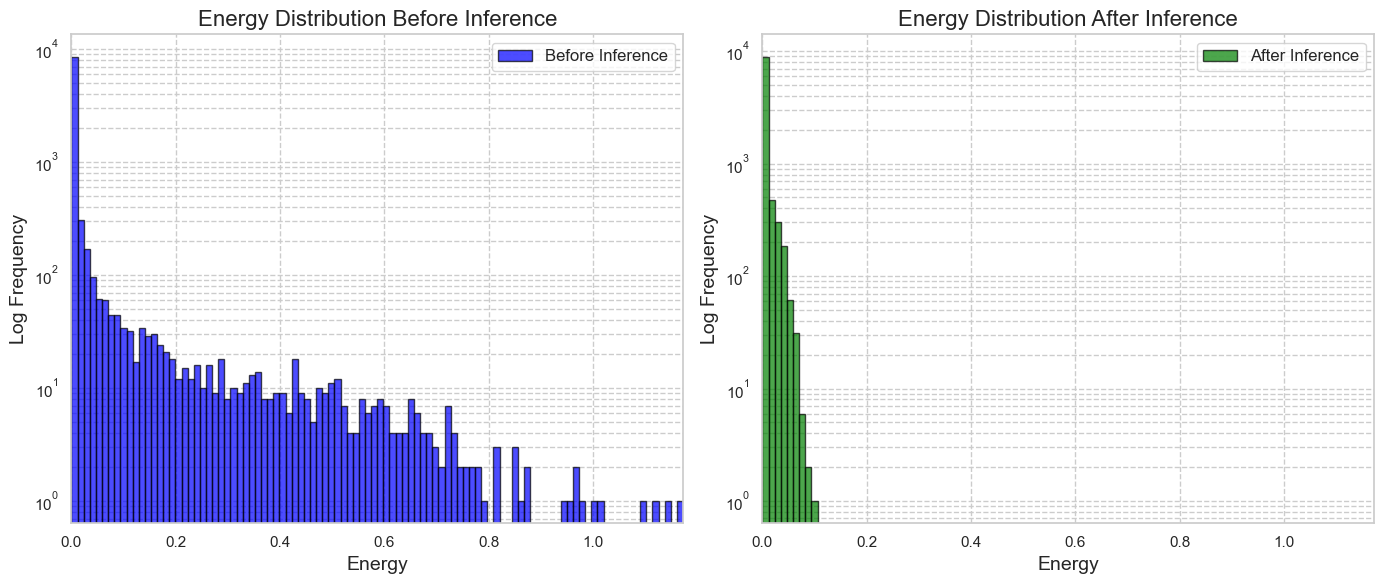

In [14]:
# create a semi-log plot or log-linear plot where the x-axis is linear and the y-axis is logarithmic
def plot_energy_distribution_histograms(e_pre, e_post, bins=100):
    """
    Plot histograms of the energy distributions before and after inference steps.

    Parameters:
    - e_pre: JAX array of energies before inference steps.
    - e_post: JAX array of energies after inference steps.
    - bins: Number of bins for the histogram.
    """
    # Convert JAX arrays to NumPy arrays for plotting
    e_pre_np = np.array(e_pre)
    e_post_np = np.array(e_post)

    # Use seaborn style for better aesthetics
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 6))

    # Determine the common x limits and common bins
    all_data = np.concatenate((e_pre_np, e_post_np))
    x_min, x_max = all_data.min(), all_data.max()
    common_bins = np.linspace(x_min, x_max, bins + 1)

    # Plot histogram for e_pre
    plt.subplot(1, 2, 1)
    counts_pre, _, _ = plt.hist(e_pre_np, bins=common_bins, alpha=0.7, color='blue', edgecolor='black', label='Before Inference')
    plt.yscale('log')
    plt.title('Energy Distribution Before Inference', fontsize=16)
    plt.xlabel('Energy', fontsize=14)
    plt.ylabel('Log Frequency', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, which="both", ls="--")
    plt.xlim(x_min, x_max)

    # Plot histogram for e_post
    plt.subplot(1, 2, 2)
    counts_post, _, _ = plt.hist(e_post_np, bins=common_bins, alpha=0.7, color='green', edgecolor='black', label='After Inference')
    plt.yscale('log')
    plt.title('Energy Distribution After Inference', fontsize=16)
    plt.xlabel('Energy', fontsize=14)
    plt.ylabel('Log Frequency', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, which="both", ls="--")
    plt.xlim(x_min, x_max)

    # Adjust layout for better fit
    plt.tight_layout()
    
    # Save the figure
    #plt.savefig("energy_distribution_histograms.png", dpi=300)
    
    plt.show()

# Plot the energy distributions
plot_energy_distribution_histograms(e_pre_, e_post_)

In [15]:
# show first 10 values of e_pre_ and e_post_
print(f"e_pre_[:10]: {e_pre_[:10]}")
print()
print(f"e_post_[:10]: {e_post_[:10]}")

e_pre_[:10]: [8.3446469e-07 4.2915253e-06 2.5656661e-03 2.1457649e-06 3.2991525e-03
 1.8227168e-03 1.7165990e-05 7.8563817e-04 4.4279805e-01 7.1964588e-04]

e_post_[:10]: [8.3446702e-07 4.2917341e-06 2.3673265e-03 2.1457852e-06 2.7598008e-03
 1.6506579e-03 1.7169388e-05 7.4401300e-04 3.9820876e-02 6.8387849e-04]


In [16]:
#################################### OOD detection ####################################

In [17]:
# create new custom test loader with batch size equal to the entire test set
OOD_full_test_loader = create_new_test_loader_with_batch_size(test_loader=OOD_dataset.test_loader, new_batch_size=len(OOD_dataset.test_loader.dataset))

# Fetch all data from the loader
for batch in OOD_full_test_loader:
    inputs, targets = batch

# Convert to JAX arrays
OOD_X_test_jax = jnp.array(inputs)
OOD_y_test_jax = jnp.array(targets)

# Print shapes to verify
print(f"OOD_X_test_jax shape: {OOD_X_test_jax.shape}")
print(f"OOD_y_test_jax shape: {OOD_y_test_jax.shape}")


/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OOD_X_test_jax shape: (10000, 784)
OOD_y_test_jax shape: (10000,)


In [18]:
# Compute the prediction and logits for the full_test_loader
OOD_ys_test, OOD_logits_test = predict_with_logits(OOD_full_test_loader, model=model)

# Convert the outputs to JAX arrays
OOD_ys_test_jax = jnp.array(OOD_ys_test)
OOD_logits_test_jax = jnp.array(OOD_logits_test)

# Print shapes to verify
print(f"OOD_logits_test shape: {OOD_logits_test.shape}, OOD_ys_test shape: {OOD_ys_test.shape}")

# Show the first row of the logits_test and the ys_test
print(f"OOD_logits_test[0]: {OOD_logits_test[0]}")
print(f"OOD_ys_test[0]: {OOD_ys_test[0]}")

# Compute the softmax of the logits_test for the first row
OOD_logits_test_softmax = jax.nn.softmax(OOD_logits_test[0])
print(f"OOD_logits_test_softmax[0]: {OOD_logits_test_softmax}")

# Compute the sum of the logits_test_softmax
print(f"sum of the OOD_logits_test_softmax[0]: {OOD_logits_test_softmax.sum()}")

# Apply the function to logits_test_jax to get the max softmax values for each sample
OOD_max_softmax_values = max_softmax_per_sample(OOD_logits_test_jax)

# Print the max softmax values for each sample
print(f"Max softmax values for each OOD sample: {OOD_max_softmax_values}")

OOD_logits_test shape: (10000, 10), OOD_ys_test shape: (10000,)
OOD_logits_test[0]: [ -0.15038815   0.91802704  15.169584     1.1442969   -2.417934
  -0.11591867   9.077501    -7.69502     -4.4195924  -11.339571  ]
OOD_ys_test[0]: 2
OOD_logits_test_softmax[0]: [2.2163542e-07 6.4512784e-07 9.9774253e-01 8.0893466e-07 2.2953882e-08
 2.2940809e-07 2.2555918e-03 1.1723215e-10 3.1013256e-09 3.0636463e-12]
sum of the OOD_logits_test_softmax[0]: 1.0000001192092896
Max softmax values for each OOD sample: [0.99774253 0.70783895 0.7510767  ... 0.46251446 0.9979802  0.97844076]


In [19]:
# now run T inference steps on the full test set pair of test images X_test_jax and predictions ys_test_jax (note that these need to be supplied as JAX arrays) using eval_inference_on_batch()
#e_pre_, e_post_, e_lost_luca = eval_inference_on_batch(T_inf, X_test_jax, jax.nn.one_hot(ys_test_jax, 10), model=model, optim_h=optim_h)
OOD_e_pre_, OOD_e_post_ = eval_inference_on_batch(T_inf, OOD_X_test_jax, jax.nn.one_hot(OOD_ys_test_jax, 10), model=model, optim_h=optim_h)

# now assess the energy before and after the inference steps by printing the first 10 values of e_pre_ and e_post_ to see if they are different and if the energy has decreased
print(f"OOD_e_pre_[:10]: {OOD_e_pre_[:10]}")
print()
print(f"OOD_e_post_[:10]: {OOD_e_post_[:10]}")

# now compute the mean of e_pre_ and e_post_ to see if the energy has decreased on average
OOD_e_pre_mean = OOD_e_pre_.mean()
OOD_e_post_mean = OOD_e_post_.mean()
print(f"OOD_e_pre_mean: {OOD_e_pre_mean}")
print()
print(f"OOD_e_post_mean: {OOD_e_post_mean}")

OOD_e_pre_[:10]: [0.00226004 0.34553868 0.28624752 0.03005632 0.2217888  0.69949704
 0.3812342  0.03580777 0.0851589  0.08056738]

OOD_e_post_[:10]: [0.00199233 0.05094407 0.03105734 0.01199374 0.03788649 0.04644994
 0.04723711 0.01460667 0.02309208 0.02070393]
OOD_e_pre_mean: 0.20026835799217224

OOD_e_post_mean: 0.022202763706445694


In [20]:
# Compute the joint probabilities
OOD_p_pre, OOD_p_post = compute_joint_probabilities(OOD_e_pre_, OOD_e_post_)

# Print the joint probabilities for the first 10 samples
print(f"OOD_p_pre[:10]: {OOD_p_pre[:10]}")
print()
print(f"OOD_p_post[:10]: {OOD_p_post[:10]}")

# Compute the mean joint probabilities
OOD_p_pre_mean = OOD_p_pre.mean()
OOD_p_post_mean = OOD_p_post.mean()
print(f"OOD_p_pre_mean: {OOD_p_pre_mean}")
print()
print(f"OOD_p_post_mean: {OOD_p_post_mean}")

# Compute the likelihood values
OOD_likelihood_pre = compute_likelihood(OOD_p_pre)
OOD_likelihood_post = compute_likelihood(OOD_p_post)

# Print the likelihood values
print(f"OOD_likelihood_pre: {OOD_likelihood_pre}")
print(f"OOD_likelihood_post: {OOD_likelihood_post}")

OOD_p_pre[:10]: [0.9977425  0.70783895 0.7510767  0.97039086 0.8010846  0.49683514
 0.6830179  0.96482575 0.9183663  0.92259276]

OOD_p_post[:10]: [0.9980097  0.9503318  0.96941996 0.9880779  0.96282226 0.9546124
 0.95386124 0.9854995  0.9771725  0.97950894]
OOD_p_pre_mean: 0.844403862953186

OOD_p_post_mean: 0.9782575964927673
OOD_likelihood_pre: 0.0
OOD_likelihood_post: 0.0


In [21]:
# Alternatively, we can use the function to compute the likelihoods from the energies
OOD_log_likelihood_pre, OOD_likelihood_pre, OOD_log_likelihood_post, OOD_likelihood_post = compute_likelihood_from_energies(OOD_e_pre_, OOD_e_post_)

# Print the log likelihood and likelihood values
print(f"OOD_log_likelihood_pre: {OOD_log_likelihood_pre}")
print(f"OOD_likelihood_pre: {OOD_likelihood_pre}")
print()
print(f"OOD_log_likelihood_post: {OOD_log_likelihood_post}")
print(f"OOD_likelihood_post: {OOD_likelihood_post}")

OOD_log_likelihood_pre: -2002.68359375
OOD_likelihood_pre: 0.0

OOD_log_likelihood_post: -222.02764892578125
OOD_likelihood_post: 0.0


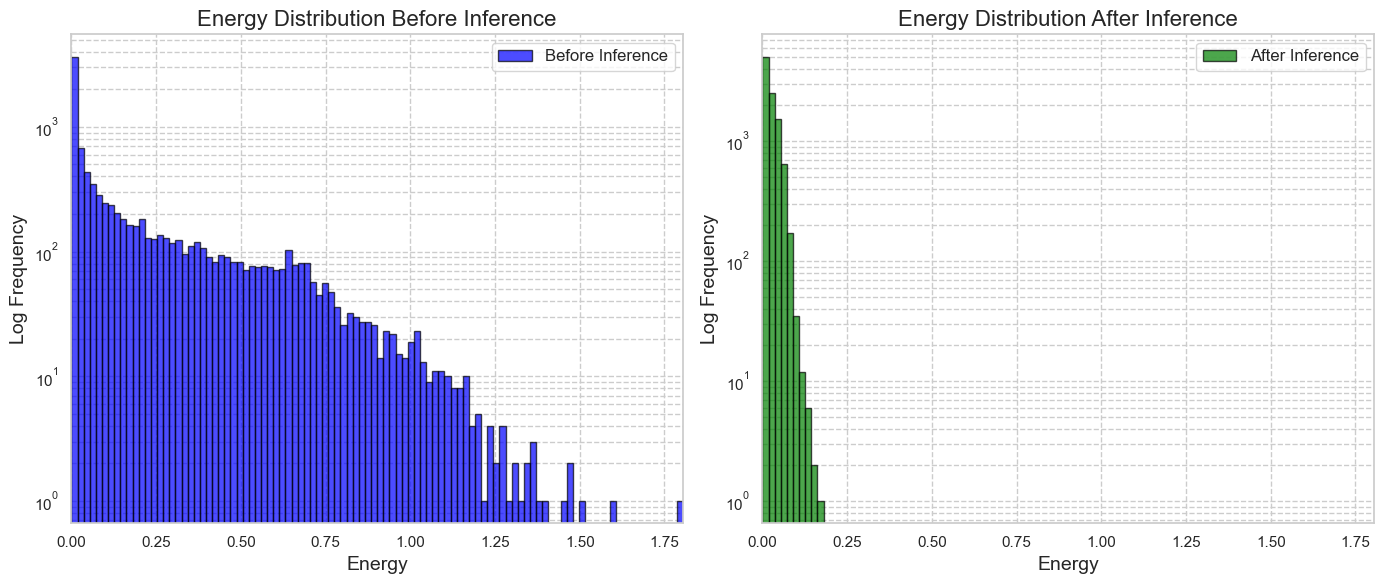

In [22]:
# Plot the energy distributions
plot_energy_distribution_histograms(OOD_e_pre_, OOD_e_post_)

In [ ]:
############################# plots comparing ID with OOD results #############################

